In [143]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.linalg import eigh
import qutip as qt
import sympy as sym

%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})

# Comparison of sqcircuit composite vs full circuit model

In [144]:
fF  = 1e-15
nH  = 1e-9
GHz = 1e9

Csh = 9
C   = 15 
CJ  = 9
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0

Csh_prime = Csh-1
C_prime   = C  +15
CJ_prime  = CJ +3
Lq_prime  = Lq +12
Lr_prime  = Lr +14
Δ_prime   = Δ  +0.1
EJ_prime  = EJ +6

CF, CR = sq_ext.C_CJ_Csh_to_CF_CR_eff(C=C, CJ=CJ, Csh=Csh)
LF, LR = sq_ext.Lq_Lr_to_LF_LR_eff(Lq=Lq, Lr=Lr, Δ=Δ)

CF_prime, CR_prime = sq_ext.C_CJ_Csh_to_CF_CR_eff(C=C_prime, CJ=CJ_prime, Csh=Csh_prime)
LF_prime, LR_prime = sq_ext.Lq_Lr_to_LF_LR_eff(Lq=Lq_prime, Lr=Lr_prime, Δ=Δ_prime)

In [145]:
Δ  = 0.1
LF = 26.5
CF = 26.9
EJ = 5.4
ω_r= 6.46
LR = 140
CR = 1/ (LR* nH)  /(ω_r*2*np.pi*GHz)**2/fF
Lq, Lr = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF, LR=LR, Δ=Δ)
C, Csh, CJ = sq_ext.CF_CR_eff_to_C_CJ_Csh(CF=CF, CR=CR)

Δ_prime = 0.1
LF_prime = 20.4
CF_prime = 22.4
EJ_prime = 9.5
ω_r_prime = 6.274
LR_prime = 100
CR_prime = 1/ (LR_prime* nH)  /(ω_r_prime*2*np.pi*GHz)**2/fF
Lq_prime, Lr_prime = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF_prime, LR=LR_prime, Δ=Δ_prime)
C_prime, Csh_prime, CJ_prime = sq_ext.CF_CR_eff_to_C_CJ_Csh(CF=CF_prime, CR=CR_prime)

In [164]:
nmax_r = 15
nmax_f = 15
CC = 10
only_inner = True
compensate_extra_cap = True
n_eig = 3

In [ ]:
H_full      = sq_ext.sq_qubit_C_qubit(CC=CC, C=C, CJ=CJ, Csh=Csh, Lq=Lq, Lr=Lr, Δ=Δ, EJ=EJ, 
                                      C_prime=C_prime, CJ_prime=CJ_prime, Csh_prime=Csh_prime, Lq_prime=Lq_prime, Lr_prime=Lr_prime, Δ_prime=Δ_prime, EJ_prime=EJ_prime,
                                      nmax_r=nmax_r, nmax_f=nmax_f, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap).hamiltonian()

H_composite = sq_ext.hamiltonian_qubit_C_qubit(CC=CC, CR=CR, CF=CF, LF=LF, LR=LR, EJ=EJ, Δ=Δ, 
                                               CR_prime=CR_prime, CF_prime=CF_prime, LF_prime=LF_prime, LR_prime=LR_prime, EJ_prime=EJ_prime, Δ_prime=Δ_prime, 
                                               nmax_r=nmax_r, nmax_f=nmax_f, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap)

MemoryError: Could not allocate memory.

In [ ]:
E_full       = sq_ext.diag(H_full,      n_eig,   remove_ground=True)[0]
E_composite  = sq_ext.diag(H_composite, n_eig,   remove_ground=True)[0]

In [ ]:
#compensate = False
E_full, E_composite

In [163]:
#compensate = False
E_full, E_composite

(array([0.000000000000, 2.928923154256, 3.365085554933]),
 array([0.000000000000, 2.981121889644, 3.426999352640]))

# Below lies the past

In [3]:
Cc = 0.1
n_eig = 3
# nmax_r_values = np.array([7, 7, 9,  9, 11, 11, 13, 13, 15])
# nmax_f_values = np.array([7, 9, 9, 11, 11, 13, 13, 15, 15])
nmax_r_values = np.array([4, 5, 6,  7    ])
nmax_f_values = np.array([12, 12, 12, 12 ])

E_sq = []
E_n  = []
E_sb = []

for nmax_r, nmax_f in zip(nmax_r_values, nmax_f_values):
    print(nmax_f)
    
    H_n = sq_ext.hamiltonian_qubit_C_qubit(nmax_r=nmax_r, nmax_f=nmax_f, Cc=Cc)
    E = sq_ext.diag(H_n, n_eig, out='GHz')[0]
    E_n.append(E-E[0])
    del(H_n)
    
    if nmax_f >= 13:
        continue
    else:
        H_sq = sq_ext.sq_qubit_C_qubit(Cc, nmax_r=nmax_r, nmax_f=nmax_f)
        H_sq.diag(n_eig)
        E_sq.append(H_sq.efreqs-H_sq.efreqs[0])
        del(H_sq)
    
E_sq = np.array(E_sq )
E_n  = np.array(E_n  )
E_sb = np.array(E_sb )   

12


AttributeError: module 'Modules.SQcircuit_extensions' has no attribute 'spin_boson_qubit_C_qubit'

In [ ]:
fig, [ax1,ax2] = plt.subplots(ncols=2)

for i, ax in enumerate([ax1,ax2]):
    ax.plot(E_sq[:,i+1], 'r')
    ax.plot(E_n [:,i+1], 'g')
    ax.plot(E_sb[:,i+1], 'b')

fig.show()

In [3]:
Cc_values = np.geomspace( 1e-3, 1, 10)
n_eig = 3
nmax_r = 4
nmax_f = 12 

E_sq = []
E_n  = []
E_sb = []

for Cc in Cc_values:
    print(Cc)
    
    H_n = sq_ext.hamiltonian_qubit_C_qubit(nmax_r=nmax_r, nmax_f=nmax_f, Cc=Cc)
    E = sq_ext.diag(H_n, n_eig, out='GHz')[0]
    E_n.append(E-E[0])
    del(H_n)

    H_sb = sq_ext.spin_boson_qubit_C_qubit(nmax_r=nmax_r, nmax_f=nmax_f, Cc=Cc)
    E = eigh(H_sb, eigvals_only=True)
    E_sb.append(E-E[0])
    del(H_sb)
    
    H_sq = sq_ext.sq_qubit_C_qubit(Cc, nmax_r=nmax_r, nmax_f=nmax_f)
    H_sq.diag(n_eig)
    E_sq.append(H_sq.efreqs-H_sq.efreqs[0])
    del(H_sq)
    
E_sq = np.array(E_sq )
E_n  = np.array(E_n  )
E_sb = np.array(E_sb )   

0.001
0.0021544346900318843
0.004641588833612777
0.01
0.021544346900318832
0.046415888336127774
0.1
0.21544346900318823
0.46415888336127775
1.0


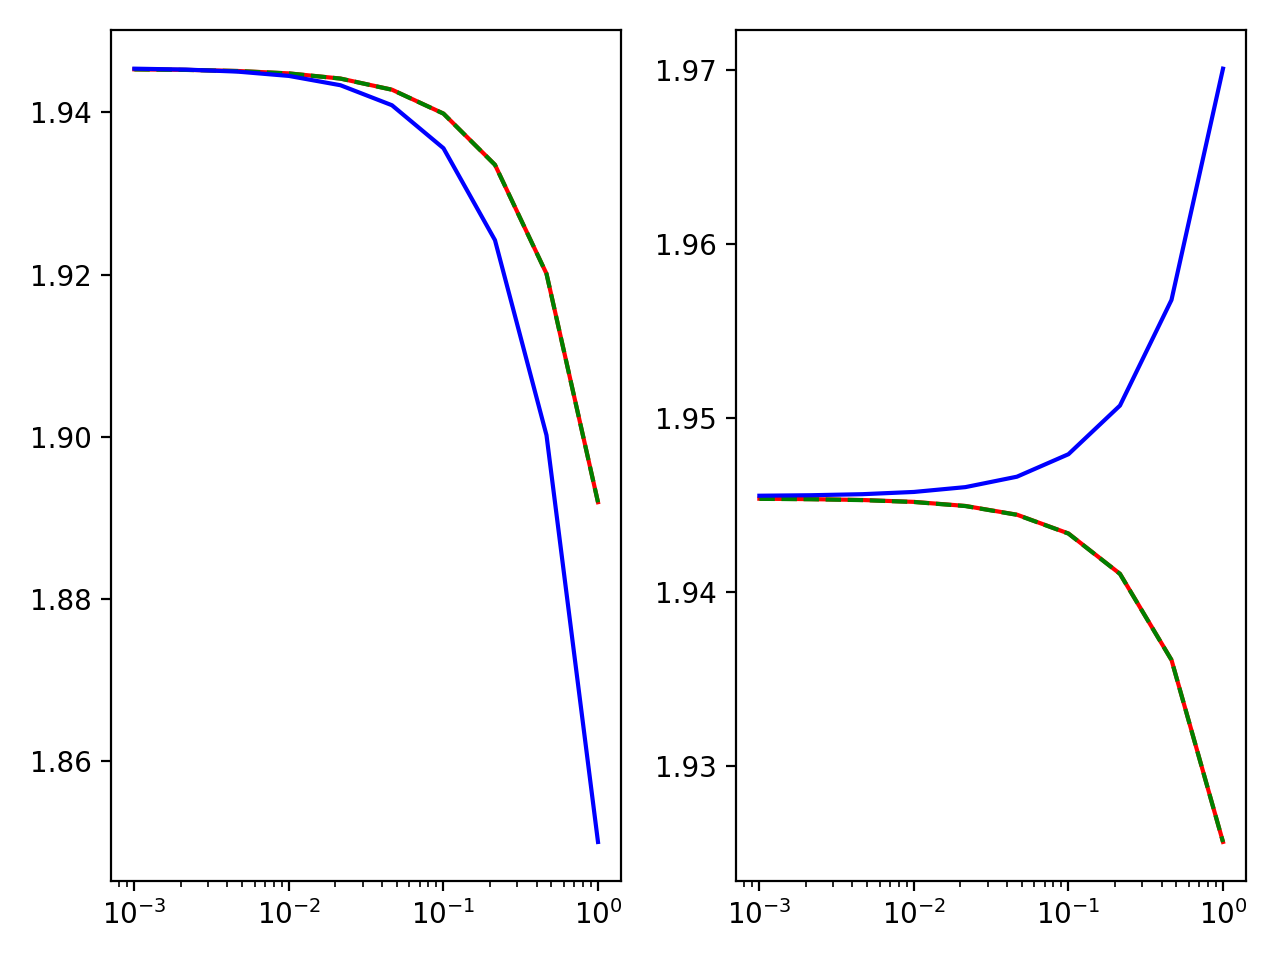

In [4]:
fig, [ax1, ax2] = plt.subplots(ncols=2, dpi =200)

for i, ax in enumerate([ax1, ax2]):
    ax.plot(Cc_values, E_sq[:, i + 1], 'r')
    ax.plot(Cc_values, E_n[:, i + 1], '--g')
    ax.plot(Cc_values, E_sb[:, i + 1], 'b')
    ax.set_xscale('log')    
fig.tight_layout()
fig.show()

In [38]:
# CR_prime=CR; CF_prime=CF; LF_prime=LF; LR_prime=LR; EJ_prime=EJ; Δ_prime=Δ
# # The basis here is changed with rspecto to the notes: first the fluxonium and then the resonator
# C0_mat =  np.array([[ CF     , 0       , 0       , 0        ],
#                     [ 0      ,  CR     , 0       , 0        ],
#                     [ 0      , 0       , CF_prime, 0        ],
#                     [ 0      , 0       , 0       , CR_prime ] ])
# 
# if only_inner == True:
#     if not compensate_extra_cap:
#         CC_mat =   np.array([[ CC / 4 ,  -CC / 4,  CC / 4,  CC / 4],
#                             [ -CC / 4 ,   CC / 4, -CC / 4, -CC / 4],
#                             [  CC / 4 ,  -CC / 4,  CC / 4,  CC / 4],
#                             [  CC / 4 ,  -CC / 4,  CC / 4,  CC / 4]])
#     else:
#         CC_mat =   np.array([[ CC / 2, 0      ,  CC / 4,  CC / 4],
#                              [ 0     ,  CC / 2, -CC / 4, -CC / 4],
#                              [ CC / 4, -CC / 4,  CC / 2, 0      ],
#                              [ CC / 4, -CC / 4, 0      ,  CC / 2]])
# 
# else:
#         CC_mat =   np.array([[ CC/2    , 0       , CC/2    , 0    ],
#                              [ 0       , CC/2    , 0       ,-CC/2 ],
#                              [ CC/2    , 0       , CC/2    , 0    ],
#                              [ 0       ,-CC/2    , 0       , CC/2 ] ])
# 
# C_mat = C0_mat + CC_mat
# 
# C_inv = np.linalg.inv(C_mat)
# CF_tilde = C_inv[0, 0] ** -1
# CR_tilde = C_inv[1, 1] ** -1
# CF_prime_tilde = C_inv[2, 2] ** -1
# CR_prime_tilde = C_inv[3, 3] ** -1
# 
# 
# 
# fluxonium       = sq_ext.sq_fluxonium(C_F_eff=CF_tilde,       L_F_eff=LF,       Δ=Δ,       EJ=EJ,       nmax_f=nmax_f)
# resonator       = sq_ext.sq_resonator(C_R_eff=CR_tilde,       L_R_eff=LR,       Δ=Δ,       EJ=EJ,       nmax_r=nmax_r)
# fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f)
# resonator_prime = sq_ext.sq_resonator(C_R_eff=CR_prime_tilde, L_R_eff=LR_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_r=nmax_r)
# 
# # fluxonium       = sq_ext.sq_fluxonium(C=C, CJ=CJ, Csh=Csh, Lq=Lq, Lr=Lr, Δ=Δ, EJ=EJ,       nmax_f=nmax_f)
# fluxonium.diag(2)
# E = fluxonium.efreqs
# E-E[0]
# 
# Lq,       Lr        = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF, LR=LR, Δ=Δ)
# Lq_prime, Lr_prime  = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF_prime, LR=LR_prime, Δ=Δ_prime)
# 
# H_uc = sq_ext.hamiltonian_qubit(fluxonium, resonator, Lq=Lq, Lr=Lr, Δ=Δ)
# H_uc_prime = sq_ext.hamiltonian_qubit(fluxonium_prime, resonator_prime, Lq=Lq_prime, Lr=Lr_prime, Δ=Δ_prime)
# 
# I_R  = qt.identity(nmax_r)
# I_F  = qt.identity(nmax_f)
# I_uc = qt.identity(H_uc.dims[0])
# 
# Q_F       = qt.tensor(fluxonium.charge_op(0)      , I_R)
# Q_R       = qt.tensor(I_F                         , resonator.charge_op(0))
# Q_F_prime = qt.tensor(fluxonium_prime.charge_op(0), I_R)
# Q_R_prime = qt.tensor(I_F                         , resonator_prime.charge_op(0))
# Q_vec = [Q_F, Q_R, Q_F_prime, Q_R_prime]
# 
# H_0 = qt.tensor(H_uc, I_uc) + qt.tensor(I_uc, H_uc_prime)